**Table of contents**<a id='toc0_'></a>    
- 1. [Triggering of LFEs by earthquakes in Parkfield    ](#toc1_)    
- 2. [Load data    ](#toc2_)    
  - 2.1. [Earthquake catalog    ](#toc2_1_)    
  - 2.2. [LFE catalog    ](#toc2_2_)    
- 3. [Measuring triggering   ](#toc3_)    
  - 3.1. [Counting LFEs in time ](#toc3_1_)    
  - 3.2. [Counting LFEs in space](#toc3_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Triggering of LFEs by earthquakes in Parkfield     [&#128285;](#toc0_)
A notebook to make a few figures and explore.

In [1]:
# Imports
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from geostuff import transect

In [2]:
# Constants
lon_range = [-121.2, -119.8]
lat_range = [35.3, 36.5]

fault_line = dict(N=dict(longitude=-121.029665, latitude=36.446555),
                  S=dict(longitude=-119.870418, latitude=35.323809))

parkfield = {'lon':-120.4327, 'lat':35.8997}
t = transect(parkfield['lon'], parkfield['lat'], fault_line['N']['longitude'], fault_line['N']['latitude'], fault_line['S']['longitude'], fault_line['S']['latitude'])
parkfield['xf'] = t[0]
parkfield['yf'] = t[1]

cities = {
    'Bitterwater': {'longitude':-121.0005, 'latitude':36.3811, 'alignment':'left'},
    'Monarch Peak': {'longitude': -120.804999, 'latitude':36.217635, 'alignment':'left'},
    'Parkfield': {'longitude':-120.4327, 'latitude':35.8997, 'alignment':'left'},
    'Cholame': {'longitude':-120.2965, 'latitude':35.7239, 'alignment':'left'},
    'Simmler': {'longitude':-119.9856, 'latitude':35.3514, 'alignment':'right'},
         }

t = transect(np.array([cities[c]['longitude'] for c in cities.keys()]), np.array([cities[c]['latitude'] for c in cities.keys()]), fault_line['N']['longitude'], fault_line['N']['latitude'], fault_line['S']['longitude'], fault_line['S']['latitude'])
for ii, c in enumerate(cities.keys()):
    cities[c]['xf'] = t[0][ii]
    cities[c]['yf'] = t[1][ii]

day0 = np.datetime64('2000-01-01')

c_lfe = 'C2'
c_eq = 'k'

# 2. <a id='toc2_'></a>Load data     [&#128285;](#toc0_)

## 2.1. <a id='toc2_1_'></a>Earthquake catalog     [&#128285;](#toc0_)

In [49]:
# Load earthquakes
path = workdir + "projects/data/Catalogs/parkfield_ncsn_ddrt_00_23/parkfield_ncsn_ddrt_00_23.txt"

COLS = ['DateTime', 'lat', 'lon', 'depth', 'mag', 'MagType', 'NbStations', 'Gap', 'Distance', 'RMS', 'Source', 'EventID']
eq = pd.read_csv(
    path,
    names=COLS, 
    skiprows=1,
)

eq["date"] = pd.to_datetime(
     eq["DateTime"],
     format='%Y/%m/%d %H:%M:%S.%f',
)
eq.sort_values(by=["date"], inplace=True)
eq.day = (eq.date - day0) / np.timedelta64(1, 'D')

indicator = (
    (eq.lat > lat_range[0]-1)
    & (eq.lat < lat_range[1]+1)
    & (eq.lon > lon_range[0]-1)
    & (eq.lon < lon_range[1]+1)
)

eq = eq[indicator]

# Project earthquakes on fault
t = transect(eq.lon.values, eq.lat.values, fault_line['S']['longitude'], fault_line['S']['latitude'], fault_line['N']['longitude'], fault_line['N']['latitude'])
eq['xf'] = t[0] - parkfield['xf']
eq['yf'] = t[1]

eq_2004 = eq[eq.date.dt.year == 2004].sort_values(by=['mag'], ascending=False).iloc[0]
eq_2012 = eq[eq.date.dt.year == 2012].sort_values(by=['mag'], ascending=False).iloc[0]

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_32707/3263424069.py:16: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  eq.day = (eq.date - day0) / np.timedelta64(1, 'D')


## 2.2. <a id='toc2_2_'></a>LFE catalog     [&#128285;](#toc0_)

In [50]:
# Shelly catalog
# --> Load catalog
CAT_PATH = workdir + 'projects/data/Catalogs/saf_lfes/saf_lfes_shelly17_extended.txt'
COL_NAMES = [ "year", "month", "day", "s_of_day", "hour", "minute", "second", "ccsum", "meancc", 
             "med_cc", "seqday", "ID", "lat", "lon", "depth", "n_chan" ]
lfe = pd.read_csv(
    CAT_PATH,
    names=COL_NAMES,
    comment='%',
    delim_whitespace=True,
    index_col=False
    )

lfe["date"] = pd.to_datetime(lfe[["year", "month", "day", "hour", "minute", "second"]])
lfe.sort_values(by=["date"], inplace=True)
print('\nShelly LFEs')
print('{:e} LFEs, spanning {:d}--{:d}'.format(len(lfe), lfe.year.min(), lfe.year.max()))
day0 = np.datetime64('2000-01-01')
lfe['day'] = (lfe.date - day0).dt.days + (lfe.date - day0).dt.seconds/(24*3600)

# Project LFEs on fault
t = transect(lfe.lon.values, lfe.lat.values, fault_line['S']['longitude'], fault_line['S']['latitude'], fault_line['N']['longitude'], fault_line['N']['latitude'])
lfe['xf'] = t[0] - parkfield['xf']
lfe['yf'] = t[1]

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_32707/2985430102.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  lfe = pd.read_csv(



Shelly LFEs
1.475910e+06 LFEs, spanning 2001--2022


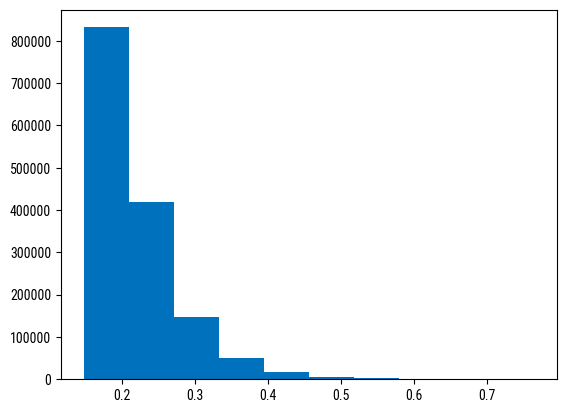

In [101]:
plt.figure()
plt.hist(lfe.meancc, bins=10)
plt.show()

In [51]:
# Store family information in a dataframe
# First, we group the LFEs by ID, lon, lat, and depth
lfe_grouped = lfe.groupby(['ID', 'lon', 'lat', 'depth'])

# Then, we create an empty dataframe to store the results
lfe_family = pd.DataFrame(columns=['id', 'lon', 'lat', 'depth', 'n_ev', 'episodicity'])

# Loop over the groups and compute the episodicity for each family
for group_name, group_data in lfe_grouped:
    # Compute the number of events in the family
    n_ev = len(group_data)

    # Compute the interevent times
    interevent_times = np.diff(group_data['date'].values) / np.timedelta64(1, 's')  # in seconds
    interevent_times = np.sort(interevent_times)[::-1]  # sort in descending order (largest first)
    cum_interevent_times = np.cumsum(interevent_times)
    
    # Index of the qth %ile of the interevent times in cum_interevent_times
    q = 2
    q_idx = int(np.ceil(len(interevent_times) * q / 100)) - 1

    # Compute the total duration of activity for the family
    duration = (group_data['date'].max() - group_data['date'].min()) / np.timedelta64(1, 's') # in seconds
    
    # Compute the episodicity
    episodicity = cum_interevent_times[q_idx] / duration
    
    # Add the result to the dataframe
    lfe_family.loc[len(lfe_family)] = [group_name[0], group_name[1], group_name[2], group_name[3], n_ev, episodicity]
    # lfe_family = pd.concat([lfe_family, pd.DataFrame.from_dict({'id': group_name[0], 'lon': group_name[1], 'lat': group_name[2], 'depth': group_name[3], 'episodicity': episodicity})], ignore_index=True)

t = transect(lfe_family.lon.values, lfe_family.lat.values, fault_line['S']['longitude'], fault_line['S']['latitude'], fault_line['N']['longitude'], fault_line['N']['latitude'])
lfe_family['xf'] = t[0] - parkfield['xf']
lfe_family['yf'] = t[1]

---

# 3. <a id='toc3_'></a>Measuring triggering    [&#128285;](#toc0_)

Several worries:
- Result is not robust: if change the distance or time window, result significantly changes

In [103]:
# Define date range and completeness for this counting session
date_range = [np.datetime64('2006-06-01'), np.datetime64('2023-01-01')]

# LFEs
lfe_in_range = lfe.copy()
cc_thr = np.median(lfe_in_range.meancc)
lfe_in_range = lfe_in_range[(lfe_in_range.date > date_range[0]) & (lfe_in_range.date < date_range[1]) & (lfe_in_range.meancc > cc_thr)]

# LFE families: count the number of events in the interval
for fid in lfe_family.id.unique():
    lfe_family.loc[lfe_family.id == fid, 'n_ev_in_range'] = len(lfe_in_range[lfe_in_range.ID == fid])

# Earthquakes
eq_in_range = eq.copy()

mc = 1.
in_date_range = (eq_in_range.date > date_range[0]) & (eq_in_range.date < date_range[1])
above_completness = eq_in_range.mag > mc

eq_in_range = eq_in_range[in_date_range & above_completness]
eq_on_fault = eq_in_range[abs(eq_in_range.yf) < 5]

## 3.1. <a id='toc3_1_'></a>Counting LFEs in time  [&#128285;](#toc0_)

In [137]:
# Parameters of this search
time_bins = np.array([-48, -24, -12, -6, -3, -1, 0, 1, 3, 6, 12, 24, 48]) # in hours
print(time_bins)
dmin = 0
dmax = 60
epicentral = True

# Select which earthquakes to use for triggering analysis
mag_min = 3.
mag_max = 5.
eq_sample = eq_in_range[(eq_in_range.mag >= mag_min) & (eq_in_range.mag <= mag_max)]

print('Number of earthquakes in the sample: {:d}'.format(len(eq_sample)))

[-48 -24 -12  -6  -3  -1   0   1   3   6  12  24  48]
Number of earthquakes in the sample: 181


Processing earthquake 181/181...
Number of earthquakes in the sample with LFEs around them: 172


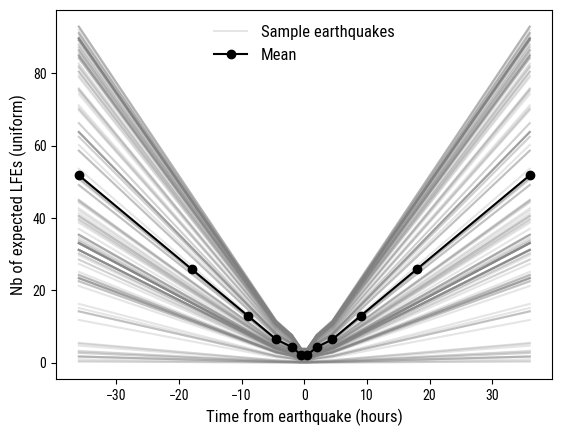

In [168]:
# Compute the expected number of LFEs around selected earthquakes
n_lfe_base_total = np.zeros(len(eq_sample))

for ii, sel_eq in enumerate(eq_sample.itertuples()):
    print('Processing earthquake {:d}/{:d}...'.format(ii+1, len(eq_sample)), end='\r')

    # Select LFE families within a given distance from the selected earthquake
    if epicentral:
        distance_to_lfe_fam = np.sqrt((lfe_family.xf - sel_eq.xf)**2 + (lfe_family.yf - sel_eq.yf)**2)
    else:
        distance_to_lfe_fam = np.sqrt((lfe_family.xf - sel_eq.xf)**2 + (lfe_family.yf - sel_eq.yf)**2 + (lfe_family.depth - sel_eq.depth)**2)

    lfe_fam_in_range = lfe_family[(distance_to_lfe_fam >= dmin) & (distance_to_lfe_fam <= dmax)]

    # Count the number of LFEs in the family
    n_lfe_base_total[ii] = lfe_fam_in_range.n_ev_in_range.sum()

# Scale the total number of LFEs to the expected number in each time bin
n_lfe_base = np.zeros((len(time_bins)-1, len(eq_sample)))

total_duration = (date_range[1] - date_range[0]) / np.timedelta64(1, 'h') # in hours
n_lfe_base_total = n_lfe_base_total / total_duration  # in events per hour

for ii in range(len(eq_sample)):
    for jj in range(len(time_bins)-1):
        n_lfe_base[jj, ii] = n_lfe_base_total[ii] * (time_bins[jj+1] - time_bins[jj])

# Remove the earthquakes that have no LFEs around them
eq_sample = eq_sample[n_lfe_base_total != 0]
n_lfe_base = n_lfe_base[:, n_lfe_base_total != 0]
print('\nNumber of earthquakes in the sample with LFEs around them: {:d}'.format(len(eq_sample)))

# Plot
fig, ax = plt.subplots()
ax.set_xlabel('Time from earthquake (hours)')
ax.set_ylabel('Nb of expected LFEs (uniform)')
for ii in range(len(eq_sample)):
    ax.plot((time_bins[1:] + time_bins[:-1])/2,  n_lfe_base[:, ii], c=to_rgba('.5', .2))
ax.plot([],  [], c=to_rgba('.5', .2), label='Sample earthquakes')
ax.plot((time_bins[1:] + time_bins[:-1]) / 2, np.mean(n_lfe_base, axis=1), 'ko-', label='Mean')
ax.legend()
plt.show()

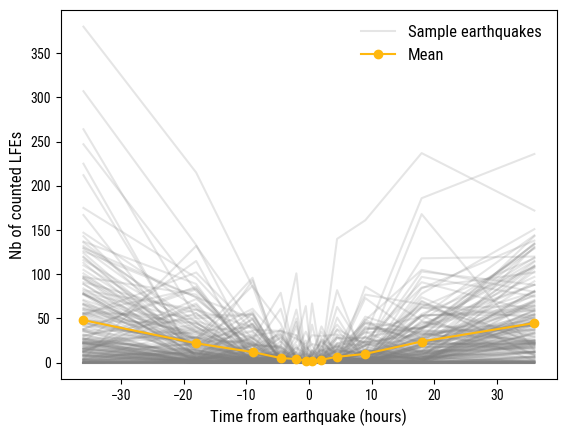

In [169]:
# Count the detected number of LFEs around the selected earthquakes
n_lfe = np.zeros((len(time_bins)-1, len(eq_sample)))

for ii, sel_eq in enumerate(eq_sample.itertuples()):
    print('Processing earthquake {:d}/{:d}...'.format(ii+1, len(eq_sample)), end='\r')

    # Only consider LFEs close to the earthquake in time
    lfe_sample = lfe_in_range[(lfe_in_range.date >= sel_eq.date - time_bins[-1]*np.timedelta64(1, 'h')) & (lfe_in_range.date <= sel_eq.date + time_bins[-1]*np.timedelta64(1, 'h'))]

    # Select LFEs within a given distance from the selected earthquake
    if epicentral: 
        distance_to_lfe = np.sqrt((lfe_sample.xf - sel_eq.xf)**2 + (lfe_sample.yf - sel_eq.yf)**2)
    else:
        distance_to_lfe = np.sqrt((lfe_sample.xf - sel_eq.xf)**2 + (lfe_sample.yf - sel_eq.yf)**2 + (lfe_sample.depth - sel_eq.depth)**2)

    lfe_sample = lfe_sample[(distance_to_lfe >= dmin) & (distance_to_lfe <= dmax)]

    # Count the number of LFEs in the family
    n_lfe[:, ii] = np.histogram((lfe_sample.date - sel_eq.date) / np.timedelta64(1, 'h'), bins=time_bins)[0]


# Plot
fig, ax = plt.subplots()
ax.set_xlabel('Time from earthquake (hours)')
ax.set_ylabel('Nb of counted LFEs')
for ii in range(len(eq_sample)):
    ax.plot((time_bins[1:] + time_bins[:-1])/2,  n_lfe[:, ii], c=to_rgba('.5', .2))
ax.plot([],  [], c=to_rgba('.5', .2), label='Sample earthquakes')
ax.plot((time_bins[1:] + time_bins[:-1]) / 2, np.mean(n_lfe, axis=1), 'o-', c='C2', label='Mean')
ax.legend()
plt.show()

In [230]:
# Bootstrap (shuffling earthquakes)
n_iter = 100

n_lfe_boot = np.zeros((len(time_bins)-1, len(eq_sample), n_iter))
eq_sample_uniform = eq_sample.copy()

for ibs in range(n_iter):
    print('Bootstrap iteration {:d}/{:d}'.format(ibs+1, n_iter), end='\r')

    # Resample earthquake occurence times, from uniform distribution, between first and last earthquake
    seconds_from_start = np.random.uniform(0, (date_range[1] - date_range[0]) / np.timedelta64(1, 's'), len(eq_sample_uniform))
    eq_sample_uniform.date = date_range[0] + pd.to_timedelta(seconds_from_start, unit='s')

    # Count the detected number of LFEs around the resampled earthquakes
    for ieq, sel_eq in enumerate(eq_sample_uniform.itertuples()):
        # Only consider LFEs close to the earthquake in time
        lfe_sample = lfe_in_range[(lfe_in_range.date >= sel_eq.date - time_bins[-1]*np.timedelta64(1, 'h')) & (lfe_in_range.date <= sel_eq.date + time_bins[-1]*np.timedelta64(1, 'h'))]

        # Select LFEs within a given distance from the selected earthquake
        if epicentral:
            distance_to_lfe = np.sqrt((lfe_sample.xf - sel_eq.xf)**2 + (lfe_sample.yf - sel_eq.yf)**2)
        else:
            distance_to_lfe = np.sqrt((lfe_sample.xf - sel_eq.xf)**2 + (lfe_sample.yf - sel_eq.yf)**2 + (lfe_sample.depth - sel_eq.depth)**2)

        lfe_sample = lfe_sample[(distance_to_lfe >= dmin) & (distance_to_lfe <= dmax)]

        # Count the number of LFEs in the family
        n_lfe_boot[:, ieq, ibs] = np.histogram((lfe_sample.date - sel_eq.date) / np.timedelta64(1, 'h'), bins=time_bins)[0]

In [108]:
# Save results?
save = False

if save:
    print('Saving bootstrap')
    results = dict(count=n_lfe, base=n_lfe_base, boot=n_lfe_boot, param=dict(dmin=dmin, dmax=dmax, mag_min=mag_min, mag_max=mag_max, time_bins=time_bins, date_range=date_range, epicentral=epicentral))
    np.save('outputs/triggering/parkfield/eq_trigger_time_m{:}-{:}_d{:}-{:}_bs{:}.npy'.format(int(mag_min), int(mag_max), int(dmin), int(dmax), int(n_iter)), results)

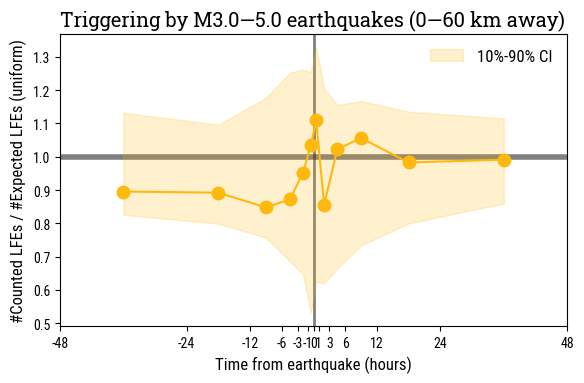

In [109]:
# Results
lfe_ratio = n_lfe / n_lfe_base
lfe_ratio_mean = np.mean(lfe_ratio, axis=1)

lfe_ratio_boot = np.zeros((len(time_bins)-1, n_iter))
for iboot in range(n_iter):
    lfe_ratio_boot[:, iboot] = np.mean(n_lfe_boot[:, :, iboot] / n_lfe_base, axis=1)

q = 20
ci_up = np.percentile(lfe_ratio_boot, 100 - q/2, axis=1)
ci_lo = np.percentile(lfe_ratio_boot, q/10, axis=1)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlabel('Time from earthquake (hours)')
ax.set_ylabel('#Counted LFEs / #Expected LFEs (uniform)')
ax.set_title('Triggering by M{:.1f}—{:.1f} earthquakes ({:.0f}—{:.0f} km away)'.format(mag_min, mag_max, dmin, dmax), loc='left', fontname='Roboto Slab')

ax.plot((time_bins[1:] + time_bins[:-1]) / 2, lfe_ratio_mean, 'o-', c='C2', zorder=2, ms=9)
ax.fill_between((time_bins[1:] + time_bins[:-1]) / 2, ci_lo, ci_up, color=to_rgba('C2', .2), zorder=1, label='{:d}%-{:d}% CI'.format(int(q/2), int(100-q/2)))

ax.axhline(1, c=to_rgba('k', .5), lw=4, zorder=0)
ax.axvline(0, lw=2, c=to_rgba('k', .5), zorder=0)

#ax.set_xscale('symlog')
ax.set_xticks(time_bins)
ax.set_xticklabels(time_bins)

ax.legend()

plt.tight_layout()
plt.show()

Top 10 contributing earthquakes:
                         date   mag   depth
45196 2021-09-14 07:38:52.280  3.79  16.375
30023 2009-12-11 03:50:43.820  3.30  10.339
36847 2014-06-25 22:01:35.940  3.37   9.305
30815 2010-06-24 23:01:08.280  3.27   6.597
45153 2021-08-17 10:09:46.770  3.03  15.048
44193 2020-04-10 08:59:14.250  3.43  10.237
28484 2009-03-09 03:15:23.780  3.12   6.117
28483 2009-03-09 03:07:52.740  3.50   6.079
23628 2006-11-13 09:19:39.190  3.03   6.063
23164 2006-08-30 15:02:27.500  3.42   7.254


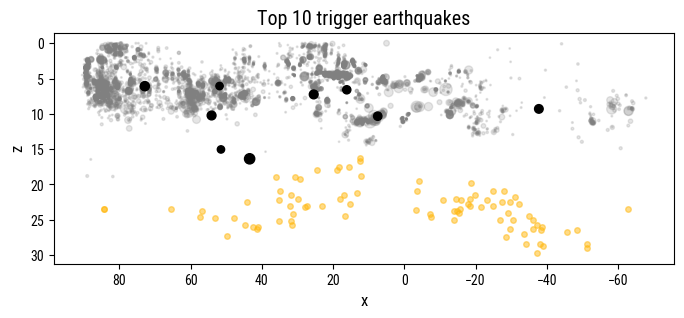

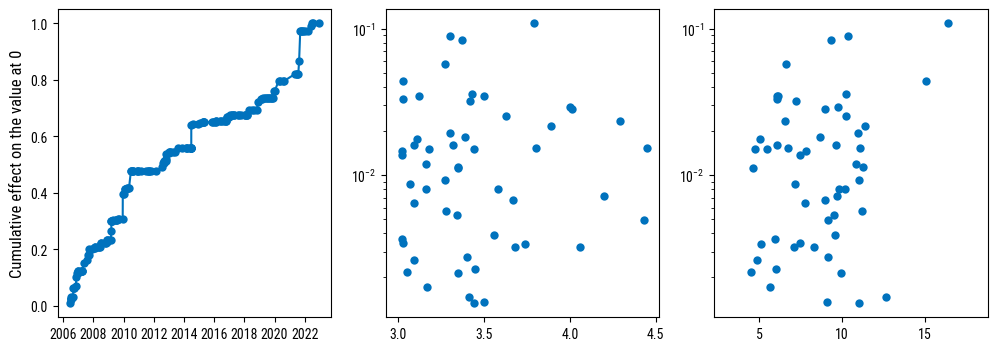

In [110]:
# Find the contributing earthquakes
ii = np.where(time_bins == 0)[0][0]
idx_top10 = np.argsort(lfe_ratio[ii, :])[::-1][:10]
eq_top10 = eq_sample.iloc[idx_top10]
print('Top 10 contributing earthquakes:')
print(eq_top10[['date', 'mag', 'depth']])

# --> Where are them
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_title('Top 10 trigger earthquakes')
ax.set_xlabel('x')
ax.set_ylabel('z')

ax.scatter(eq_on_fault.xf, eq_on_fault.depth, s=eq_on_fault.mag**3, c=[to_rgba('.5', .2) for _ in eq_on_fault.itertuples()])
ax.plot(lfe_family.xf, lfe_family.depth, 'o', ms=4, c=to_rgba('C2', .5))
ax.scatter(eq_top10.xf, eq_top10.depth, s=eq_top10.mag**3, c=[to_rgba('k') for _ in eq_top10.itertuples()])
ax.invert_yaxis()
ax.invert_xaxis()
plt.show()

# --> How much do they contribute
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ii = np.where(time_bins[:-1] == 0)[0][0]
ii += 0

ax = axes[0]
ax.plot(eq_sample.date, np.cumsum(lfe_ratio[ii, :]) / np.sum(lfe_ratio[ii, :]), 'o-', mec=[0,0,0,0])
ax.set_ylabel('Cumulative effect on the value at 0')

ax = axes[1]
ax.semilogy(eq_sample.mag, (lfe_ratio[ii, :] / np.sum(lfe_ratio[ii, :])).flatten(), 'o', mec=[0,0,0,0])

ax = axes[2]
ax.semilogy(eq_sample.depth, (lfe_ratio[ii, :] / np.sum(lfe_ratio[ii, :])).flatten(), 'o', mec=[0,0,0,0])

plt.show()

## 3.2. <a id='toc3_2_'></a>Counting LFEs in space [&#128285;](#toc0_)

In [237]:
# Parameters of this search
space_bins = np.hstack([[0], np.logspace(1, 7, num=10, base=2)])
print(space_bins)
epicentral = True

tmin = 0
tmax = 10  # in hours

# Select which earthquakes to use for triggering analysis
mag_min = 3.
mag_max = 5.
eq_sample = eq_in_range[(eq_in_range.mag >= mag_min) & (eq_in_range.mag <= mag_max)]

print('Number of earthquakes in the sample: {:d}'.format(len(eq_sample)))

[  0.           2.           3.1748021    5.0396842    8.
  12.69920842  20.1587368   32.          50.79683366  80.63494719
 128.        ]
Number of earthquakes in the sample: 181


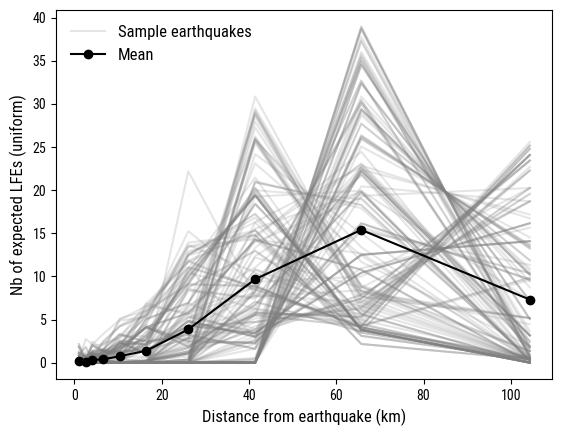

In [238]:
# Compute the baseline rate of lfe around the selected earthquakes
n_lfe_base = np.zeros((len(space_bins)-1, len(eq_sample)))

for ii, sel_eq in enumerate(eq_sample.itertuples()):
    print('Processing earthquake {:d}/{:d}...'.format(ii+1, len(eq_sample)), end='\r')
    # Distance to each LFE family
    if epicentral:
        distance_to_lfe_fam = np.sqrt((lfe_family.xf - sel_eq.xf)**2 + (lfe_family.yf - sel_eq.yf)**2)
    else:
        distance_to_lfe_fam = np.sqrt((lfe_family.xf - sel_eq.xf)**2 + (lfe_family.yf - sel_eq.yf)**2 + (lfe_family.depth - sel_eq.depth)**2)
    
    # Count the number of LFE events at in the distance range to each earthquakes, total number in the date range
    n_lfe_base[:, ii] = np.histogram(distance_to_lfe_fam, weights=lfe_family.n_ev_in_range, bins=space_bins)[0] 
    n_lfe_base[:, ii] = n_lfe_base[:, ii] / ((date_range[1] - date_range[0])/np.timedelta64(1, 'h')) * (tmax - tmin)

# Plot
fig, ax = plt.subplots()
ax.set_xlabel('Distance from earthquake (km)')
ax.set_ylabel('Nb of expected LFEs (uniform)')
for ii in range(len(eq_sample)):
    ax.plot((space_bins[1:] + space_bins[:-1])/2,  n_lfe_base[:, ii], c=to_rgba('.5', .2))
ax.plot([],  [], c=to_rgba('.5', .2), label='Sample earthquakes')
ax.plot((space_bins[1:] + space_bins[:-1]) / 2, np.mean(n_lfe_base, axis=1), 'ko-', label='Mean')
ax.legend()
plt.show()

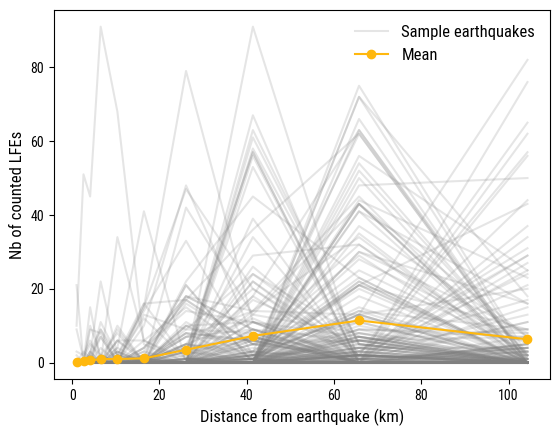

In [239]:
# Count the number of lfe detections around trigger earthquakes
n_lfe = np.zeros((len(space_bins)-1, len(eq_sample)))

for ii, sel_eq in enumerate(eq_sample.itertuples()):
    print('Processing earthquake {:d}/{:d}...'.format(ii+1, len(eq_sample)), end='\r')
    # Only consider LFEs close to the earthquake in time
    lfe_sample = lfe_in_range[(lfe_in_range.date >= sel_eq.date + tmin*np.timedelta64(1, 'h')) & (lfe_in_range.date <= sel_eq.date + tmax*np.timedelta64(1, 'h'))]

    # Distance to each LFE family
    if epicentral:
        distance_to_lfe = np.sqrt((lfe_sample.xf - sel_eq.xf)**2 + (lfe_sample.yf - sel_eq.yf)**2)
    else:
        distance_to_lfe = np.sqrt((lfe_sample.xf - sel_eq.xf)**2 + (lfe_sample.yf - sel_eq.yf)**2 + (lfe_sample.depth - sel_eq.depth)**2)
    
    # Count the number of LFE events at in the distance range to each earthquakes, total number in the date range
    n_lfe[:, ii] = np.histogram(distance_to_lfe, bins=space_bins)[0]

# Plot
fig, ax = plt.subplots()
ax.set_xlabel('Distance from earthquake (km)')
ax.set_ylabel('Nb of counted LFEs')
for ii in range(len(eq_sample)):
    ax.plot((space_bins[1:] + space_bins[:-1])/2,  n_lfe[:, ii], c=to_rgba('.5', .2))
ax.plot([],  [], c=to_rgba('.5', .2), label='Sample earthquakes')
ax.plot((space_bins[1:] + space_bins[:-1]) / 2, np.mean(n_lfe, axis=1), 'o-', c='C2', label='Mean')
ax.legend()
plt.show()

In [240]:
# Bootstrap (shuffling earthquakes)
n_iter = 10

n_lfe_boot = np.zeros((len(space_bins)-1, len(eq_sample), n_iter))
eq_sample_uniform = eq_sample.copy()

t0 = time.time()
for iboot in range(n_iter):
    print('Bootstrapping {:d}/{:d}...'.format(iboot+1, n_iter), end='\r')

    # Resample earthquake occurence times, from uniform distribution, between the first and last earthquake
    seconds_from_start = np.random.uniform(0, (date_range[1] - date_range[0]) / np.timedelta64(1, 's'), len(eq_sample_uniform))
    eq_sample_uniform.date = date_range[0] + pd.to_timedelta(seconds_from_start, unit='s')

    # Count lfes around resampled earthquakes
    for ii, sel_eq in enumerate(eq_sample_uniform.itertuples()):
        # Only consider LFEs close to the earthquake in time
        lfe_sample = lfe_in_range[(lfe_in_range.date - sel_eq.date >= tmin * np.timedelta64(1, 'h')) & (lfe_in_range.date - sel_eq.date <= tmax * np.timedelta64(1, 'h'))]

        # Compute the distance between the earthquake and all LFEs close in time
        if epicentral:
            distance_to_lfe = np.sqrt((lfe_sample.xf - sel_eq.xf)**2 + (lfe_sample.yf - sel_eq.yf)**2)
        else:
            distance_to_lfe = np.sqrt((lfe_sample.xf - sel_eq.xf)**2 + (lfe_sample.yf - sel_eq.yf)**2 + (lfe_sample.depth - sel_eq.depth)**2)

        # Count the number of LFEs in each time bin
        n_lfe_boot[:, ii, iboot], _ = np.histogram(distance_to_lfe, bins=space_bins)
print(time.time() - t0)

14.0824370384216310...


In [241]:
# Save results?
save = False

if save:
    print('Saving bootstrap')
    results = dict(count=n_lfe, base=n_lfe_base, boot=n_lfe_boot, param=dict(tmin=tmin, tmax=tmax, mag_min=mag_min, mag_max=mag_max, space_bins=space_bins, date_range=date_range, epicentral=epicentral))
    np.save('outputs/triggering/parkfield/eq_trigger_space_m{:}-{:}_t{:}-{:}_bs{:}.npy'.format(int(mag_min), int(mag_max), int(tmin), int(tmax), int(n_iter)), results)

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_32707/1221026264.py:2: RuntimeWarning: invalid value encountered in divide
  lfe_ratio = n_lfe / n_lfe_base


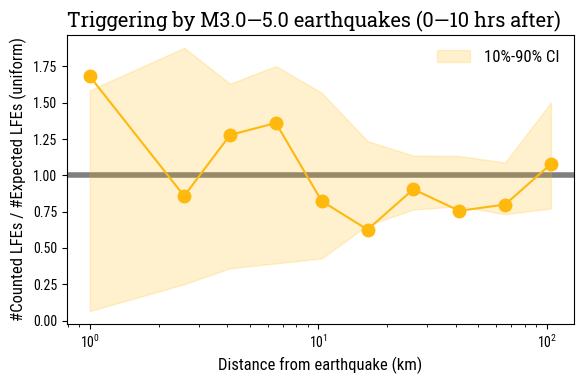

In [242]:
# Results
lfe_ratio = n_lfe / n_lfe_base
lfe_ratio[np.isnan(lfe_ratio)] = 0

lfe_ratio_mean = np.zeros(len(space_bins[:-1]))
for ii in range(len(lfe_ratio)):
    no0 = n_lfe_base[ii, :] != 0  # don't use earthquakes that cannot see any LFEs at this distance
    lfe_ratio_mean[ii] = np.mean(n_lfe[ii, no0].astype(float) / n_lfe_base[ii, no0].astype(float))

lfe_ratio_boot = np.zeros((len(space_bins)-1, n_iter))
for iboot in range(np.shape(n_lfe_boot)[-1]):
    for ix in range(len(space_bins)-1):
        no0 = n_lfe_base[ix, :] != 0
        lfe_ratio_boot[ix, iboot] = np.mean(n_lfe_boot[ix, no0, iboot] / n_lfe_base[ix, no0].astype(float))

q = 20
ci_up = np.percentile(lfe_ratio_boot, 100 - q/2, axis=1)
ci_lo = np.percentile(lfe_ratio_boot, q/10, axis=1)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlabel('Distance from earthquake (km)')
ax.set_ylabel('#Counted LFEs / #Expected LFEs (uniform)')
ax.set_title('Triggering by M{:.1f}—{:.1f} earthquakes ({:.0f}—{:.0f} hrs after)'.format(mag_min, mag_max, tmin, tmax), loc='left', fontname='Roboto Slab')

ax.plot((space_bins[1:] + space_bins[:-1]) / 2, lfe_ratio_mean, 'o-', c='C2', zorder=2, ms=9)
ax.fill_between((space_bins[1:] + space_bins[:-1]) / 2, ci_lo, ci_up, color=to_rgba('C2', .2), zorder=1, label='{:d}%-{:d}% CI'.format(int(q/2), int(100-q/2)))

ax.axhline(1, c=to_rgba('k', .5), lw=4, zorder=0)
ax.axvline(0, lw=2, c=to_rgba('k', .5), zorder=0)
ax.set_xscale('log')
ax.legend()

plt.tight_layout()
plt.show()

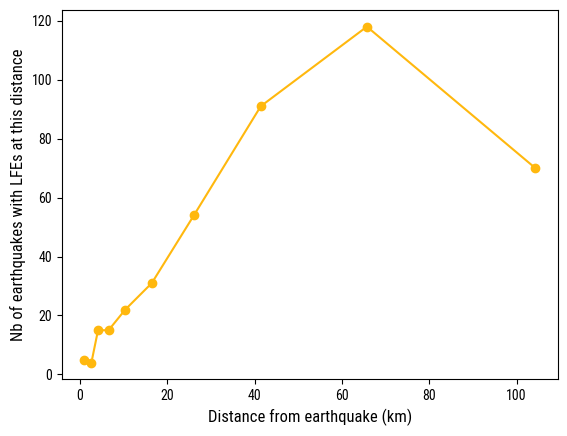

In [ ]:
# How many earthquakes for each space bin
fig, ax = plt.subplots()
ax.set_xlabel('Distance from earthquake (km)')
ax.set_ylabel('Nb of earthquakes with LFEs at this distance')

ax.plot((space_bins[1:] + space_bins[:-1]) / 2, np.sum(n_lfe != 0, axis=1), 'o-', c='C2')

plt.show()

In [ ]:
# Which are the contributing earthquakes
ii = np.where(space_bins[:-1] == 0)[0][0]
ii += 0

# --> Print their date and magnitude
eq_sample_top10 = eq_sample.iloc[(np.argsort(lfe_ratio[ii, :].flatten())[::-1][:10])]
print(eq_sample_top10[['date', 'mag']])

# --> Where are them
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_title('Top 10 trigger earthquakes')
ax.set_xlabel('x')
ax.set_ylabel('z')

ax.scatter(eq_in_range.xf, eq_in_range.depth, s=eq_in_range.mag**3, c=to_rgba('.5', .2))
ax.plot(lfe_family.xf, lfe_family.depth, 'o', ms=4, c=to_rgba('C2', .5))
ax.scatter(eq_sample_top10.xf, eq_sample_top10.depth, s=eq_sample_top10.mag**3, c='k')
ax.invert_yaxis()
ax.invert_xaxis()
plt.show()

# --> How much do they contribute
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes[0]
ax.plot(eq_sample.date, np.cumsum(lfe_ratio[ii, :]) / np.sum(lfe_ratio[ii, :]), 'o-', mec=[0,0,0,0])
ax.set_ylabel('Cumulative effect on the value at 0')

ax = axes[1]
ax.semilogy(eq_sample.mag, (lfe_ratio[ii, :] / np.sum(lfe_ratio[ii, :])).flatten(), 'o', mec=[0,0,0,0])

ax = axes[2]
ax.semilogy(eq_sample.depth, (lfe_ratio[ii, :] / np.sum(lfe_ratio[ii, :])).flatten(), 'o', mec=[0,0,0,0])

plt.show()